In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
from tqdm import tqdm



In [2]:


# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = ImageFolder(root=self.root_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  
        label = int(os.path.basename(os.path.dirname(self.dataset.imgs[idx][0]))) 
        return img, label


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.3,0.3,0.3], std=[1,1,1])  
])

data_path = os.path.expanduser('~/Documents/Nepali-Digit')
dataset = CustomDataset(root_dir=data_path, transform=transform)


train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


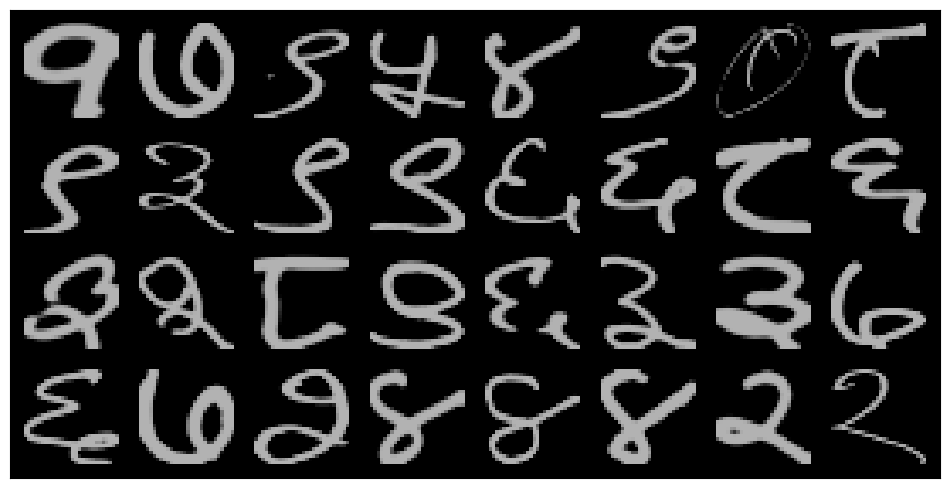

In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


def show(dl):
    for images , label in dl:
        fig , ax  = plt.subplots(figsize = (12 , 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8). permute(1,2,0))
        break

show(train_dataloader)

In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3 , 32 , kernel_size=(3,3) , stride=1 , padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size= ( 3,3 ) , stride = 1 , padding = 1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear( 8192 ,  512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512 , 10)


    def forward(self , x):

        x = self.act1(self.conv1(x))
        x = self.drop1(x)

        x = self.act2(self.conv2(x))
        x = self.pool2(x)

        x = self.flat(x)

        x = self.act3(self.fc3(x))
        x = self.drop3(x)

        x = self.fc4(x)



In [5]:
model = CNNModel()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters() , lr= 0.001 , momentum= 0.9)

In [8]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.1, verbose=True)

    # Training loop
early_stopping_counter = 0
current_lr = 0.001
lr_decreases = 0 
best_val_loss = float('inf')
num_epochs = 25 # Count of learning rate decreases

for epoch in range(num_epochs):
    with tqdm(train_dataloader, unit="hello", desc=f"Epoch {epoch+1}/{num_epochs}" , colour="GREEN") as tepoch:
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0            
        for inputs, labels in tepoch:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
                
                # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
                # Update progress bar description and postfix
            tepoch.set_postfix(train_loss=running_loss/ len(train_dataloader), train_accuracy=correct/total)
            
        # Calculate epoch training loss and accuracy
        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_train_accuracy = correct / total
        train_loss_history.append(epoch_train_loss)
        train_accuracy_history.append(epoch_train_accuracy)
            
            # Validation
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        val_running_loss = 0.0
            
        with torch.no_grad():
            with tqdm(val_dataloader, unit="check", desc="Validation"  , colour="RED") as tval:
                for inputs, labels in tval:
                    outputs = model(inputs)
                    
                    val_loss = criterion(outputs, labels)
                    val_running_loss += val_loss.item()
                        
                        # Calculate validation accuracy
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                        
                        # Update progress bar postfix for validation
                    tval.set_postfix(val_loss=val_running_loss/(len(val_dataloader)), val_accuracy=correct/total)

print(outputs)

Epoch 1/25:   0%|          | 0/438 [00:00<?, ?hello/s]


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType